<a href="https://colab.research.google.com/github/beatlesatani/OCR_project/blob/main/Japanese_handwritten_text_detection_horizontal_vertical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).

【2値化処理画像 - Binarization】
  画像の2値化と白部分の膨張を工夫することで、大まかな文字領域の検出（ブロック検出）をしています。
  この段階で、文字が「白」として処理できていないと輪郭の検出がしにくいようでした。


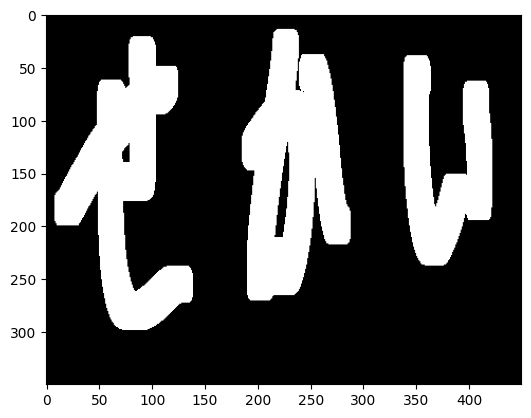


【横書きの文字領域の輪郭検出・抽出結果 - Text detection・Contours】
  枠が大きすぎる場合・小さすぎる場合には輪郭を除去しています。画像によって微調整する必要があります。


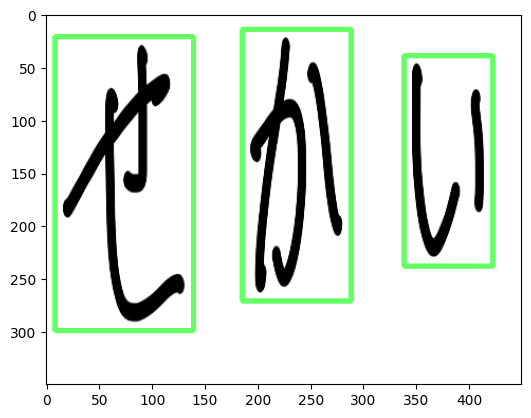

['block_ROI_img0.png', 'block_ROI_img1.png', 'block_ROI_img2.png']
['row_column_ROI_img0.png', 'row_column_ROI_img1.png', 'row_column_ROI_img2.png']


'\n#### ７．関数の実行等 #### \n\n## 横書き・縦書きの行・列領域の検出（行と列の検出）する関数（text_row_column_detection）の実行\n#「block_ROI_img〜.png」という名前のファイルの取得\nfile_list = glob.glob(\'block_ROI_img*png\')\n\n#「block_ROI_img〜.png」（〜の部分に0や1などの数字が入る）という名前のファイルを0から順番に並び替え\nprint(natsorted(file_list))\n\n#「block_ROI_img〜.png」のファイルを順番に、\n# 横書き・縦書きの行・列領域の検出（行と列の検出）する関数（text_row_column_detection）に入れる\nfor file in natsorted(file_list):\n  text_row_column_detection(file) \n\n\n## 個別の文字の検出（文字検出）する関数（find_draw_contours）の実行\n#「row_column_ROI_img〜.png」という名前のファイルの取得\nfile_list = glob.glob(\'row_column_ROI_img*png\')\n\n#「row_column_ROI_img〜.png」（〜の部分に0や1などの数字が入る）という名前のファイルを0から順番に並び替え\nprint(natsorted(file_list))\n\n#「row_column_ROI_img〜.png」のファイルを順番に、\n# 個別の文字の検出（文字検出）する関数（find_draw_contours）に入れる\nfor file in natsorted(file_list):\n  find_draw_contours(file) \n\n\nprint(\'\n\n＊\u3000上手く検出できない場合は「３．各種設定」の所で、「膨張処理の設定」「輪郭のカット設定」を変更してみてください。\')\n\n\n\n\n#### ８．出力した画像ファイルの削除 #### \n# 今回のコードでは、画像を一度作成後に、プログラム内で利用し、最後に作成した画像を削除しています\n# ＊\u30

In [47]:

#### 1.import ####

import os
import cv2
import numpy as np
from imutils import contours
import matplotlib.pyplot as plt
import glob
from natsort import natsorted # ファイルを自然順（0,1,2,3,・・,20,21,・・30,31,・・）に並べるために「natsort」を利用

from google.colab import drive
drive.mount('/content/gdrive')

#### ２．set up pictures ####
input_file = "/content/gdrive/MyDrive/pictures/world.png"

#### 3.setting ####
horizontal = 0
OCR_mode = 0


# 膨張処理の設定
#【横書き】大まかな文字領域の検出（ブロック検出）のための膨張処理（カーネルサイズ・膨張処理回数）の設定
block_horizontal_kernel_hight = 5  # カーネルの縦の高さ
block_horizontal_kernel_width = 5  # カーネルの横の幅
block_horizontal_iterations = 4    # 膨張処理回数


#【横書き】行領域の検出（行検出）のための膨張処理（カーネルサイズ・膨張処理回数）の設定
column_horizontal_kernel_hight = 2  # カーネルの縦の高さ
column_horizontal_kernel_width = 5  # カーネルの横の幅
column_horizontal_iterations = 6    # 膨張処理回数


#【横書き】個別の文字の検出（文字検出）のための膨張処理（カーネルサイズ・膨張処理回数）の設定
character_horizontal_kernel_hight = 5  # カーネルの縦の高さ 5
character_horizontal_kernel_width = 3  # カーネルの横の幅 3
character_horizontal_iterations = 2    # 膨張処理回数


# 輪郭のカット設定
# ブロック検出：文字領域検出した輪郭の「横幅」が、以下の範囲なら輪郭を残す
block_horizontal_height_minimum = 5  # 最小値（ピクセル）
block_horizontal_height_max = 1000   # 最大値（ピクセル）

# ブロック検出：文字領域検出した輪郭の「縦の高さ」が、以下の範囲なら輪郭を残す
block_vertical_height_minimum = 5  # 最小値（ピクセル）
block_vertical_height_max = 1000   # 最大値（ピクセル）


# 行検出：文字領域検出した輪郭の「横幅」が、以下の範囲なら輪郭を残す
row_column_horizontal_height_minimum = 5  # 最小値（ピクセル）
row_column_horizontal_height_max = 1000   # 最大値（ピクセル）

# 列検出：文字領域検出した輪郭の「縦の高さ」が、以下の範囲なら輪郭を残す
row_column_vertical_height_minimum = 5  # 最小値（ピクセル）
row_column_vertical_height_max = 1000   # 最大値（ピクセル）


# 個別の文字領域検出した輪郭の「横幅」が、以下の範囲なら輪郭を残す
character_text_detection_horizontal_height_minimum = 10  # 最小値（ピクセル）
character_text_detection_horizontal_height_max = 200    # 最大値（ピクセル）

# 個別の文字領域検出した輪郭の「縦の高さ」が、以下の範囲なら輪郭を残す
character_text_detection_vertical_height_minimum = 10  # 最小値（ピクセル）
character_text_detection_vertical_height_max = 200     # 最大値（ピクセル）





####  ４．大まかな文字領域の検出（ブロック検出） ####
# 画像から、ブロック検出をおこないます
# 「block_ROI_img〜.png」（ブロック検出画像）を作成します
# 「block_text-detection.png」（ブロック検出の結果を、元の画像に描画した画像）を作成します


# 画像から文字領域を検出・抽出する処理
def block_contours (OCR_input_file):

  # 画像の読み込み
  img = cv2.imread(OCR_input_file)
  width = 450
  height = 350
  img = cv2.resize(img, (width, height))

  # モノクロ・グレースケール画像へ変換（2値化前の画像処理）
  img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  # 2値化（Binarization）：白（1）黒（0）のシンプルな2値画像に変換
  retval, img_binary = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

  # 白部分の膨張処理（Dilation）：モルフォロジー変換 - 2値画像を対象
  if OCR_mode == 0: # 横書きの場合
    kernel = np.ones((block_horizontal_kernel_hight, block_horizontal_kernel_width),np.uint8) # カーネル（構造的要素）：全要素の値が1の縦横が任意のピクセルのカーネル
    img_dilation = cv2.dilate(img_binary,kernel,iterations = block_horizontal_iterations) #「iterations=」繰り返し膨張処理を行う回数を指定
  elif OCR_mode == 1: # 縦書きの場合
    kernel = np.ones((block_vertical_kernel_hight, block_vertical_kernel_width),np.uint8) # カーネル（構造的要素）：全要素の値が1の縦横が任意のピクセルのカーネル
    img_dilation = cv2.dilate(img_binary,kernel,iterations = block_vertical_iterations) #「iterations=」繰り返し膨張処理を行う回数を指定

  # 解説用のコメント（2値化）
  print('\n【2値化処理画像 - Binarization】')
  print('  画像の2値化と白部分の膨張を工夫することで、大まかな文字領域の検出（ブロック検出）をしています。')
  print('  この段階で、文字が「白」として処理できていないと輪郭の検出がしにくいようでした。')

  # 膨張処理後の2値化画像の表示
  plt.imshow(cv2.cvtColor(img_dilation, cv2.COLOR_BGR2RGB))
  plt.show()


  # 輪郭の検出
  #「findContours」の返り値「cnts（contours）」は輪郭毎の座標組・「hierarchy」は輪郭の階層構造
  #「cv2.RETR_EXTERNAL」：最も外側の輪郭を返す
  #「cv2.CHAIN_APPROX_SIMPLE」：輪郭上の全点の情報を保持しない。輪郭の情報を圧縮
  cnts, hierarchy = cv2.findContours(img_dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  if OCR_mode == 0: # 横書きの場合
    cnts, hierarchy = contours.sort_contours(cnts, method='top-to-bottom') # 上から下に並び替え
  elif OCR_mode == 1: # 縦書きの場合
    cnts, hierarchy = contours.sort_contours(cnts, method='right-to-left') # 右から左に並び替え

  # ROI（Region of Interest：興味領域・対象領域）抽出用の初期設定
  block_ROI_index = 0

  # 抽出した輪郭を「x, y, w（横の幅）, h（縦の高さ）」の単純なリストに変換
  result = []
  for contour in cnts:
    x, y, w, h = cv2.boundingRect(contour) # 外接矩形の左上の位置は(x,y)，横の幅と縦の高さは(w,h)

    # 大きすぎる小さすぎる領域を除去。処理する画像サイズに合わせて微調整が必要
    if not block_vertical_height_minimum < w < block_vertical_height_max:
      continue
    if not block_horizontal_height_minimum < h < block_horizontal_height_max: #輪郭の描画は画像サイズを超えることもあるようでした。
      continue

    # ROI抽出：画像の切り抜きと保存
    block_ROI = img[y:y+h, x:x+w]
    cv2.imwrite('block_ROI_img{}.png'.format(block_ROI_index), block_ROI)
    block_ROI_index += 1
    #resultに要素を追加
    result.append([x, y, w, h])


  # 画面に矩形の輪郭を描画 （描画機能）
  for x, y, w, h in result:
      cv2.rectangle(img, (x, y), (x+w, y+h), (100, 255, 100), 3)  # 色の指定はRGB(100, 255, 100)。「3」は 太さ。数字を大きくすると太い輪郭が描画される。


  # 解説用のコメント（文字領域の輪郭検出・抽出）
  if OCR_mode == 0: # 横書きの場合
    print('\n【横書きの文字領域の輪郭検出・抽出結果 - Text detection・Contours】')
  elif OCR_mode == 1:  #縦書きの場合
    print('\n【縦書きの文字領域の輪郭検出・抽出結果 - Text detection・Contours】')
  print('  枠が大きすぎる場合・小さすぎる場合には輪郭を除去しています。画像によって微調整する必要があります。')

  # 文字領域の輪郭検出・抽出結果の表示
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.savefig('block_text-detection.png', dpi=300)  # 抽出結果の画像ファイルも保存しています。「dpi」は何も指定しないと dpi=72
  plt.show()



## 大まかな文字領域の検出（ブロック検出）の関数（block_contours）の実行
block_contours (input_file)





#### ５．横書き・縦書きの行・列領域の検出（行と列の検出） ####
# 画像から行と列の検出をします
# 「row_column_ROI_img〜.png」（行や列を検出した画像）を作成します

def text_row_column_detection (OCR_input_file):
  # 画像の読み込み
  row_column_img = cv2.imread(OCR_input_file)

  # モノクロ・グレースケール画像へ変換（2値化前の画像処理）
  row_column_img_gray = cv2.cvtColor(row_column_img, cv2.COLOR_BGR2GRAY)

  # 2値化（Binarization）：白（1）黒（0）のシンプルな2値画像に変換
  retval, row_column_img_binary = cv2.threshold(row_column_img_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

  # 白部分の膨張処理（Dilation）：モルフォロジー変換 - 2値画像を対象
  if OCR_mode == 0: # 横書きの場合
    kernel = np.ones((column_horizontal_kernel_hight, column_horizontal_kernel_width),np.uint8) # カーネル（構造的要素）：全要素の値が1の縦横が任意のピクセルのカーネル
    row_column_img_dilation = cv2.dilate(row_column_img_binary,kernel,iterations = column_horizontal_iterations) #「iterations=」繰り返し膨張処理を行う回数を指定
    print('\n【各行の2値化処理画像 - Binarization】')
  elif OCR_mode == 1:  #縦書きの場合
    kernel = np.ones((row_vertical_kernel_hight, row_vertical_kernel_width),np.uint8) # カーネル（構造的要素）：全要素の値が1の縦横が任意のピクセルのカーネル
    row_column_img_dilation = cv2.dilate(row_column_img_binary,kernel,iterations = row_vertical_iterations) #「iterations=」繰り返し膨張処理を行う回数を指定
    print('\n【各列の2値化処理画像 - Binarization】')
  print('  画像の2値化と白部分の膨張を工夫することで、文字と文字の繋がりを検出しています。')
  print('  画像のテキストの文字の「太さ」「行間」「文字間隔」によっては、画像のリサイズの微調整や膨張処理の微調整が必要です。')

  # 膨張処理後の2値化画像の表示
  plt.imshow(cv2.cvtColor(row_column_img_dilation, cv2.COLOR_BGR2RGB))
  plt.show()

  # 輪郭の検出
  #「findContours」の返り値「contours」は輪郭毎の座標組・「hierarchy」は輪郭の階層構造
  #「cv2.RETR_EXTERNAL」：最も外側の輪郭を返す
  #「cv2.CHAIN_APPROX_SIMPLE」：輪郭上の全点の情報を保持しない。輪郭の情報を圧縮
  cnts, hierarchy = cv2.findContours(row_column_img_dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  if OCR_mode == 0: # 横書きの場合
    cnts, hierarchy = contours.sort_contours(cnts, method='top-to-bottom') # 上から下に並び替え
  elif OCR_mode == 1: # 縦書きの場合
    cnts, hierarchy = contours.sort_contours(cnts, method='right-to-left') # 右から左に並び替え

  # 抽出した輪郭を「x, y, w（横の幅）, h（縦の高さ）」の単純なリストに変換
  row_column_result = []
  for row_column_contour in cnts:
    x, y, w, h = cv2.boundingRect(row_column_contour) # 外接矩形の左上の位置は(x,y)，横の幅と縦の高さは(w,h)

    # 大きすぎる小さすぎる領域を除去。処理する画像サイズに合わせて微調整が必要
    if not row_column_vertical_height_minimum < w < row_column_vertical_height_max:
      continue
    if not row_column_horizontal_height_minimum < h < row_column_horizontal_height_max: #輪郭の描画は画像サイズを超えることもあるようでした。
      continue

    # resultに要素を追加
    row_column_result.append([x, y, w, h])

  # 画面に矩形の輪郭を描画 （描画機能：for〜cv2.rectangleまでの2行をコメントアウト、または削除すると輪郭の描画を無効にできます）
  for x, y, w, h in row_column_result:
      cv2.rectangle(row_column_img, (x, y), (x+w, y+h), (100, 255, 100), 2)  # 色の指定はRGB(100, 255, 100)。「2」は 太さ。数字を大きくすると太い輪郭が描画される。

  # 解説用のコメント（輪郭検出・抽出）
  if OCR_mode == 0: # 横書きの場合
    print('\n【各行の文字の輪郭検出・抽出結果 - Text recognition・Contours】')
  elif OCR_mode == 1:  #縦書きの場合
    print('\n【各列の文字の輪郭検出・抽出結果 - Text recognition・Contours】')
  print('  枠が大きすぎる場合・小さすぎる場合には輪郭を除去しています。画像によって微調整する必要があります。')

  # 輪郭検出・抽出結果の表示
  plt.imshow(cv2.cvtColor(row_column_img, cv2.COLOR_BGR2RGB))
  plt.show()




##「row_column_ROI_img〜.png」の画像を保存するための処理


#「block_ROI_img〜.png」という名前のファイルの取得
file_list = glob.glob('block_ROI_img*png')

#「block_ROI_img〜.png」（〜の部分に0や1などの数字が入る）という名前のファイルを0から順番に並び替え
print(natsorted(file_list))

# ROI（Region of Interest：興味領域・対象領域）抽出用の初期設定
row_column_ROI_index = 0

#「block_ROI_img〜.png」のファイルを順番に処理する
for file in natsorted(file_list):
  row_column_img = cv2.imread(file)

  # モノクロ・グレースケール画像へ変換（2値化前の画像処理）
  row_column_img_gray = cv2.cvtColor(row_column_img, cv2.COLOR_BGR2GRAY)

  # 2値化（Binarization）：白（1）黒（0）のシンプルな2値画像に変換
  retval, row_column_img_binary = cv2.threshold(row_column_img_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

  # 白部分の膨張処理（Dilation）：モルフォロジー変換 - 2値画像を対象
  if OCR_mode == 0: # 横書きの場合
    kernel = np.ones((column_horizontal_kernel_hight, column_horizontal_kernel_width),np.uint8) # カーネル（構造的要素）：全要素の値が1の縦横が任意のピクセルのカーネル
    row_column_img_dilation = cv2.dilate(row_column_img_binary,kernel,iterations = column_horizontal_iterations) #「iterations=」繰り返し膨張処理を行う回数を指定
    #print('\n【各行の2値化処理画像 - Binarization】')
  elif OCR_mode == 1:  #縦書きの場合
    kernel = np.ones((row_vertical_kernel_hight, row_vertical_kernel_width),np.uint8) # カーネル（構造的要素）：全要素の値が1の縦横が任意のピクセルのカーネル
    row_column_img_dilation = cv2.dilate(row_column_img_binary,kernel,iterations = row_vertical_iterations) #「iterations=」繰り返し膨張処理を行う回数を指定

  cnts, hierarchy = cv2.findContours(row_column_img_dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  if OCR_mode == 0: # 横書きの場合
      cnts, hierarchy = contours.sort_contours(cnts, method='top-to-bottom') # 上から下に並び替え
  elif OCR_mode == 1: # 縦書きの場合
      cnts, hierarchy = contours.sort_contours(cnts, method='right-to-left') # 右から左に並び替え

  # 抽出した輪郭を「x, y, w（横の幅）, h（縦の高さ）」の単純なリストに変換
  for row_column_contour in cnts:
    x, y, w, h = cv2.boundingRect(row_column_contour) # 外接矩形の左上の位置は(x,y)，横の幅と縦の高さは(w,h)

    # ROI抽出：画像の切り抜きと保存。 ここで最後の処理だけの行と列の画像ファイルが残るのみなのでできない
    row_column_ROI = row_column_img[y:y+h, x:x+w]
    cv2.imwrite('row_column_ROI_img{}.png'.format(row_column_ROI_index), row_column_ROI)

    row_column_ROI_index += 1







#### ６．個別の文字の検出（文字検出）＋ 個別の文字検出枠の描画設定 ####
# 「row_column_ROI_img〜.png」（行や列を検出した画像）から、行や列ごとに個別の文字を検出します
# 「OCR_img〜.png」（個別文字検出画像）を作成します


def find_draw_contours (OCR_input_file):
  # 画像の読み込み
  predict_img = cv2.imread(OCR_input_file)

  # モノクロ・グレースケール画像へ変換（2値化前の画像処理）
  predict_img_gray = cv2.cvtColor(predict_img, cv2.COLOR_BGR2GRAY)

  # 2値化（Binarization）：白（1）黒（0）のシンプルな2値画像に変換
  retval, predict_img_binary = cv2.threshold(predict_img_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

  # 白部分の膨張処理（Dilation）：モルフォロジー変換 - 2値画像を対象
  if OCR_mode == 0: # 横書きの場合
    kernel = np.ones((character_horizontal_kernel_hight, character_horizontal_kernel_width),np.uint8) # カーネル（構造的要素）：全要素の値が1の縦横が任意のピクセルのカーネル
    predict_img_dilation = cv2.dilate(predict_img_binary,kernel,iterations = character_horizontal_iterations) #「iterations=」繰り返し膨張処理を行う回数を指定
  elif OCR_mode == 1: #縦書きの場合
    kernel = np.ones((character_vertical_kernel_hight, character_vertical_kernel_width),np.uint8) # カーネル（構造的要素）：全要素の値が1の縦横が任意のピクセルのカーネル
    predict_img_dilation = cv2.dilate(predict_img_binary,kernel,iterations = character_vertical_iterations) #「iterations=」繰り返し膨張処理を行う回数を指定

  # 解説用のコメント（2値化）
  if OCR_mode == 0: # 横書きの場合
    print('\n【各行の2値化処理画像 - Binarization】')
  elif OCR_mode == 1: #縦書きの場合
    print('\n【各列の2値化処理画像 - Binarization】')
  print('  画像の2値化と白部分の膨張を工夫することで、個別の文字を検出しやすいようにしています。')
  print('  画像のテキストの文字の「太さ」「行間」「文字間隔」によっては、画像のリサイズや膨張処理の微調整が必要です。')
  print('  この段階で、文字が他の文字と繋がってしまうと、個別の文字の検出ができなくなります。')

  # 膨張処理後の2値化画像の表示
  plt.imshow(cv2.cvtColor(predict_img_dilation, cv2.COLOR_BGR2RGB))
  plt.show()



  # 輪郭の検出
  #「findContours」の返り値「contours」は輪郭毎の座標組・「hierarchy」は輪郭の階層構造
  #「cv2.RETR_EXTERNAL」：最も外側の輪郭を返す
  #「cv2.CHAIN_APPROX_SIMPLE」：輪郭上の全点の情報を保持しない。輪郭の情報を圧縮
  cnts, hierarchy = cv2.findContours(predict_img_dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  if OCR_mode == 0: # 横書きの場合
      cnts, hierarchy = contours.sort_contours(cnts, method='left-to-right') # 左から右に並び替え
  elif OCR_mode == 1: # 縦書きの場合
      cnts, hierarchy = contours.sort_contours(cnts, method='top-to-bottom') # 上から下に並び替え

  # ROI（Region of Interest：興味領域・対象領域）抽出用の初期設定
  OCR_index = 0

  # 抽出した輪郭を「x, y, w（横の幅）, h（縦の高さ）」の単純なリストに変換
  predict_result = []
  for predict_contour in cnts:
    x, y, w, h = cv2.boundingRect(predict_contour) # 外接矩形の左上の位置は(x,y)，横の幅と縦の高さは(w,h)

    # 大きすぎる小さすぎる領域を除去。処理する画像サイズに合わせて微調整が必要
    if not character_text_detection_horizontal_height_minimum < w < character_text_detection_horizontal_height_max:
      continue
    if not character_text_detection_vertical_height_minimum < h < character_text_detection_vertical_height_max: #輪郭の描画は画像サイズを超えることもあるようでした。
      continue

    # ROI抽出：画像の切り抜きと保存。
    predict_ROI = predict_img[y:y+h, x:x+w]
    cv2.imwrite('OCR_img{}.png'.format(OCR_index), predict_ROI)
    OCR_index += 1

    #resultに要素を追加
    predict_result.append([x, y, w, h])

  ## 個別の文字検出枠の描画設定：画面に矩形の輪郭を描画
  # 描画機能：for〜cv2.rectangleまでの2行をコメントアウト、または削除すると輪郭の描画を無効にできます
  # 実際に文字認識・OCRさせる場合には、ここの輪郭が無い方が精度が上がりやすいです
  for x, y, w, h in predict_result:
      cv2.rectangle(predict_img, (x, y), (x+w, y+h), (100, 255, 100), 2)  # 色の指定はRGB(100, 255, 100)。「2」は 太さ。数字を大きくすると太い輪郭が描画される。


  # 解説用のコメント（輪郭検出・抽出）
  if OCR_mode == 0: # 横書きの場合
    print('\n【各行の文字の輪郭検出・抽出結果 - Text recognition・Contours】')
  print('  枠が大きすぎる場合・小さすぎる場合には輪郭を除去しています。画像によって微調整する必要があります。')


  # 輪郭検出・抽出結果の表示
  plt.imshow(cv2.cvtColor(predict_img, cv2.COLOR_BGR2RGB))
  plt.show()





##「OCR_img〜.png」の画像を保存するための処理

#「row_column_ROI_img〜.png」という名前のファイルの取得
file_list = glob.glob('row_column_ROI_img*png')

#「row_column_ROI_img〜.png」（〜の部分に0や1などの数字が入る）という名前のファイルを0から順番に並び替え
print(natsorted(file_list))

# ROI（Region of Interest：興味領域・対象領域）抽出用の初期設定
OCR_index = 0

#「row_column_ROI_img〜.png」のファイルを順番に処理する
for file in natsorted(file_list):
  predict_img = cv2.imread(file)

  # モノクロ・グレースケール画像へ変換（2値化前の画像処理）
  predict_img_gray = cv2.cvtColor(predict_img, cv2.COLOR_BGR2GRAY)

  # 2値化（Binarization）：白（1）黒（0）のシンプルな2値画像に変換
  retval, predict_img_binary = cv2.threshold(predict_img_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

  # 白部分の膨張処理（Dilation）：モルフォロジー変換 - 2値画像を対象
  if OCR_mode == 0: # 横書きの場合
    kernel = np.ones((character_horizontal_kernel_hight, character_horizontal_kernel_width),np.uint8) # カーネル（構造的要素）：全要素の値が1の縦横が任意のピクセルのカーネル
    predict_img_dilation = cv2.dilate(predict_img_binary,kernel,iterations = character_horizontal_iterations) #「iterations=」繰り返し膨張処理を行う回数を指定
  elif OCR_mode == 1: #縦書きの場合
    kernel = np.ones((character_vertical_kernel_hight, character_vertical_kernel_width),np.uint8) # カーネル（構造的要素）：全要素の値が1の縦横が任意のピクセルのカーネル
    predict_img_dilation = cv2.dilate(predict_img_binary,kernel,iterations = character_vertical_iterations) #「iterations=」繰り返し膨張処理を行う回数を指定

  cnts, hierarchy = cv2.findContours(predict_img_dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  if OCR_mode == 0: # 横書きの場合
      cnts, hierarchy = contours.sort_contours(cnts, method='left-to-right') # 左から右に並び替え
  elif OCR_mode == 1: # 縦書きの場合
      cnts, hierarchy = contours.sort_contours(cnts, method='top-to-bottom') # 上から下に並び替え

  # 抽出した輪郭を「x, y, w（横の幅）, h（縦の高さ）」の単純なリストに変換
  predict_result = []
  for predict_contour in cnts:
    x, y, w, h = cv2.boundingRect(predict_contour) # 外接矩形の左上の位置は(x,y)，横の幅と縦の高さは(w,h)

    # 大きすぎる小さすぎる領域を除去。処理する画像サイズに合わせて微調整が必要
    if not character_text_detection_horizontal_height_minimum < w < character_text_detection_horizontal_height_max:
      continue
    if not character_text_detection_vertical_height_minimum < h < character_text_detection_vertical_height_max: #輪郭の描画は画像サイズを超えることもあるようでした。
      continue

    # ROI抽出：画像の切り抜きと保存。→　再学習用に別プログラムを作成する OCR_index自体は、文字数判断のために必要かもしれない。
    predict_ROI = predict_img[y:y+h, x:x+w]
    cv2.imwrite('OCR_img{}.png'.format(OCR_index), predict_ROI)
    OCR_index += 1




'''
#### ７．関数の実行等 ####

## 横書き・縦書きの行・列領域の検出（行と列の検出）する関数（text_row_column_detection）の実行
#「block_ROI_img〜.png」という名前のファイルの取得
file_list = glob.glob('block_ROI_img*png')

#「block_ROI_img〜.png」（〜の部分に0や1などの数字が入る）という名前のファイルを0から順番に並び替え
print(natsorted(file_list))

#「block_ROI_img〜.png」のファイルを順番に、
# 横書き・縦書きの行・列領域の検出（行と列の検出）する関数（text_row_column_detection）に入れる
for file in natsorted(file_list):
  text_row_column_detection(file)


## 個別の文字の検出（文字検出）する関数（find_draw_contours）の実行
#「row_column_ROI_img〜.png」という名前のファイルの取得
file_list = glob.glob('row_column_ROI_img*png')

#「row_column_ROI_img〜.png」（〜の部分に0や1などの数字が入る）という名前のファイルを0から順番に並び替え
print(natsorted(file_list))

#「row_column_ROI_img〜.png」のファイルを順番に、
# 個別の文字の検出（文字検出）する関数（find_draw_contours）に入れる
for file in natsorted(file_list):
  find_draw_contours(file)


print('\n\n＊　上手く検出できない場合は「３．各種設定」の所で、「膨張処理の設定」「輪郭のカット設定」を変更してみてください。')




#### ８．出力した画像ファイルの削除 ####
# 今回のコードでは、画像を一度作成後に、プログラム内で利用し、最後に作成した画像を削除しています
# ＊　例外として「block_text-detection.png」（ブロック検出の結果を、元の画像に描画した画像）は、削除していません
# そのため、次に文字検出を実行する画像内の文字検出数などが少ないと、誤作動が起きるリスクがあります
# 画像ファイルを保存した場合には、一度生成された画像を削除してから、新たな画像の文字検出を試みてください
# 「個別の文字領域検出した画像（OCR_img*png）の削除」のコードをコメントアウトまたは、削除すると個別の文字検出画像を保存できます

# 大まかな文字領域の検出（ブロック検出）した画像（「block_ROI_img〜.png」）の削除：保存したい場合は、
# ここをコメントアウト（または削除）すると画像を保存できます
file_list = glob.glob("block_ROI_img*png")
for file in natsorted(file_list):
  os.remove(file)


# 横書き・縦書きの行・列領域の検出（行と列の検出）した画像（「row_column_ROI_img〜.png」）の削除：保存したい場合は、
# ここをコメントアウト（または削除）すると画像を保存できます
file_list = glob.glob("row_column_ROI_img*png")
for file in natsorted(file_list):
  os.remove(file)


# 個別の文字の検出（文字検出）画像（「OCR_img〜.png」）の削除：保存したい場合は、
# ここをコメントアウト（または削除）すると画像を保存できます（今回は一部の画像のみ。ステップ4のプログラムでは全てに対応。）
file_list = glob.glob('OCR_img*png')
for file in natsorted(file_list):
  os.remove(file)


'''


<br><br>
<b>④ 出力された画像のリセット用プログラム</b><br>
上記のコードの「８．出力した画像ファイルの削除のためのプログラム」の機能をOFFにした場合等に活用できます。

In [ ]:
'''
import glob
import os


# 大まかな文字領域の検出（ブロック検出）した画像（「block_ROI_img〜.png」）の削除
file_list = glob.glob("block_ROI_img*png")
for file in file_list:
  os.remove(file)


# 横書き・縦書きの行・列領域の検出（行と列の検出）した画像（「row_column_ROI_img〜.png」）の削除
file_list = glob.glob('row_column_ROI_img*png')
for file in file_list:
  os.remove(file)


# 個別の文字の検出（文字検出）画像（「OCR_img〜.png」）の削除
file_list = glob.glob('OCR_img*png')
for file in file_list:
  os.remove(file)
'''

In [51]:
from tensorflow.keras.models import load_model
model = load_model("/content/gdrive/MyDrive/hiragana_recognition_cnn.h5")
image_width = 32  # ここを変更。使用する学習済みモデルと同じwidth（横幅）を指定
image_height = 32 # ここを変更。使用する学習済みモデルと同じheight（縦の高さ）を指定

[]
['row_column_ROI_img0.png', 'row_column_ROI_img1.png', 'row_column_ROI_img2.png']

【各行の2値化処理画像 - Binarization】
  画像の2値化と白部分の膨張を工夫することで、個別の文字を検出しやすいようにしています。
  画像のテキストの文字の「太さ」「行間」「文字間隔」によっては、画像のリサイズや膨張処理の微調整が必要です。
  この段階で、文字が他の文字と繋がってしまうと、個別の文字の検出ができなくなります。


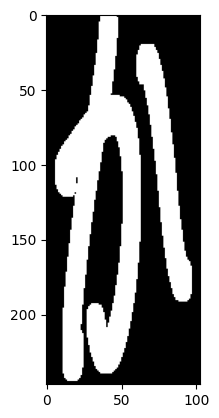


【各行の文字の輪郭検出・抽出結果 - Text recognition・Contours】
  枠が大きすぎる場合・小さすぎる場合には輪郭を除去しています。画像によって微調整する必要があります。


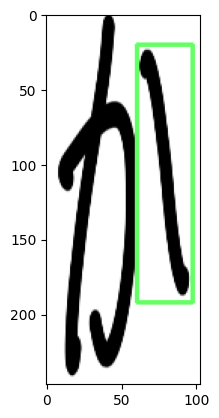

TypeError: ignored

In [52]:
#### ８．画像判定のためのプログラム ####
# オリジナルデータセットで学習させた学習済みモデルを使って画像判定
# 「行や列ごとの判定」「全文の判定」ができます

# 画像の各種設定
# 認識できる文字を増やしたい場合は、ここに文字を追加します（事前に、文字を増やした「学習済みモデル」を作成する必要があります）
# ステップ1〜2 で利用した以下のプログラム
# 【日本語の手書き文字画像認識用：Pythonサンプルコード】KerasでCNN機械学習。自作・自前画像のオリジナルデータセットで画像認識入門 のプログラム
# Keras-CNN-Japanese-handwritten-character-text-originaldataset.ipynb
# https://colab.research.google.com/drive/1TEjxN8xZVC0k08WzG_Ie8dyaGloSqJzA?usp=sharing
# 内の「④ 自前画像で判定（手書き日本語画像）」で出力された順番に合わせて文字を追加します
folder = ['あ','い','う','え','お',
              'か','き','く','け','こ',
              'さ','し','す','せ','そ',
              'た','ち','つ','て','と',
              'な','に','ぬ','ね','の',
              'は','ひ','ふ','へ','ほ',
              'ま','み','む','め','も',
              'や','ゆ','よ',
              'ら','り','る','れ','ろ',
              'わ','を','ん']


# 行や列ごとに個別文字認識をする処理
def cognition(OCR_input_file):
  # 解説用コメント
  if OCR_mode == 0: # 横書きの場合
    print('\n【各行の画像判別結果 - Prediction】デフォルトではグレースケールの画像を判定できます。')
  elif OCR_mode == 1:  #縦書きの場合
     print('\n【各列の画像判別結果 - Prediction】デフォルトではグレースケールの画像を判定できます。')
  print(' 「color_setting = 3」に変更するとカラー版の学習済みモデルにも対応できます。 \n')
  print('  OCR結果（予測結果）： \n')
  # 読み込んだ画像データを予測
  for i, predict_contour in enumerate(cnts):
      x, y, w, h = predict_contour

      # 画像データを取り出す
      img_extraction = predict_img[y:y+h, x:x+w]

      # データを学習済みモデルのデータに合わせる
      if color_setting == 1:
        gazou = cv2.cvtColor(img_extraction, cv2.COLOR_BGR2GRAY)  # モノクロ・グレースケールの場合
      elif color_setting == 3:
        gazou = cv2.cvtColor(img_extraction, cv2.COLOR_BGR2RGB)   # カラーの場合
      gazou = cv2.resize(gazou, (image_width, image_height))
      suuti = gazou.reshape(image_width, image_height, color_setting).astype('float32')/255

      # 予測する
      n = model.predict(np.array([suuti]))


      # 画面に結果を表示
      plt.subplot(1, OCR_index, i + 1)
      plt.imshow(cv2.cvtColor(img_extraction, cv2.COLOR_BGR2RGB))
      plt.axis('off')
      plt.title(folder[n.argmax()] )
      print(folder[n.argmax()] , end='')  #横一列に表示させるため「, end=''」を追加
  plt.show()



#「OCR結果：全文」を表示させる処理
def cognition_text(OCR_input_file):
  # 読み込んだ画像データを予測
  if color_setting == 1: # モノクロ・グレースケールの場合
    gazou = cv2.imread(OCR_input_file, 0)
  elif color_setting == 3:  # カラーの場合
    gazou = cv2.imread(OCR_input_file, 1)

  # データを学習済みモデルのデータに合わせる
  gazou = cv2.resize(gazou, (image_width, image_height))
  if color_setting == 1: # モノクロ・グレースケールの場合
    suuti = gazou.reshape(image_width, image_height, 1).astype('float32')/255
  elif color_setting == 3:  # カラーの場合
    suuti = gazou.reshape(image_width, image_height, 3).astype('float32')/255

  # 予測する
  n = model.predict(np.array([suuti]))
  print(folder[n.argmax()] , end='')  #横一列に表示させるため「, end=' '」を追加





#### ９．関数の実行など ####

## 横書き・縦書きの行・列領域の検出（行と列の検出）する関数（text_row_column_detection）の実行
#「rotate_block_ROI_img〜.png」（角度補正後のブロック検出画像）という名前のファイルの取得
file_list = glob.glob('rotate_block_ROI_img*png')
print(natsorted(file_list))
#「rotate_block_ROI_img〜.png」の画像を0から順番に1つずつ処理
for file in natsorted(file_list):
  text_row_column_detection(file)


## 個別の文字の検出（文字検出）する関数（find_draw_contours）の実行
## 個別の文字認識をする関数（cognition）の実行
#「row_column_ROI_img〜.png」（行や列を検出した画像）という名前のファイルの取得
file_list = glob.glob('row_column_ROI_img*png')
print(natsorted(file_list))
#「row_column_ROI_img〜.png」を0から順番に1つずつ処理
for file in natsorted(file_list):
  cnts, predict_img,OCR_index = find_draw_contours(file)
  cognition(file)


##「OCR結果：全文」を表示させる関数（cognition_text）の実行
#「OCR_img〜.png」（個別の文字検出画像）という名前のファイルの取得
file_list = glob.glob('OCR_img*png')
print(natsorted(file_list))
print('\n【OCR結果：全文】\n')
#「OCR_img〜.png」の画像を0から順番に1つずつ認識させることで全文結果を表示
for file in natsorted(file_list):
  cognition_text(file)
